In [1]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests #The requests library for HTTP requests in Python
import math #The Python math module
import re
import statsmodels.api as sm


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler

In [2]:
ticker = yf.Ticker("MELI")

In [3]:
df = ticker.history(period="max")

In [4]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-08-10 00:00:00-04:00,21.317949,28.100933,20.348951,27.616434,9800300,0.0,0.0
2007-08-13 00:00:00-04:00,30.232728,38.440135,28.100932,30.668776,3162100,0.0,0.0
2007-08-14 00:00:00-04:00,31.443977,31.686227,29.050552,29.099003,609300,0.0,0.0
2007-08-15 00:00:00-04:00,29.273424,29.273424,27.180389,27.674578,991800,0.0,0.0
2007-08-16 00:00:00-04:00,27.374183,29.069929,24.283080,27.228834,1107500,0.0,0.0


In [5]:
df.reset_index(inplace=True)

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2007-08-10 00:00:00-04:00,21.317949,28.100933,20.348951,27.616434,9800300,0.0,0.0
1,2007-08-13 00:00:00-04:00,30.232728,38.440135,28.100932,30.668776,3162100,0.0,0.0
2,2007-08-14 00:00:00-04:00,31.443977,31.686227,29.050552,29.099003,609300,0.0,0.0
3,2007-08-15 00:00:00-04:00,29.273424,29.273424,27.180389,27.674578,991800,0.0,0.0
4,2007-08-16 00:00:00-04:00,27.374183,29.069929,24.283080,27.228834,1107500,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          4126 non-null   datetime64[ns, America/New_York]
 1   Open          4126 non-null   float64                         
 2   High          4126 non-null   float64                         
 3   Low           4126 non-null   float64                         
 4   Close         4126 non-null   float64                         
 5   Volume        4126 non-null   int64                           
 6   Dividends     4126 non-null   float64                         
 7   Stock Splits  4126 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 258.0 KB


<AxesSubplot: title={'center': 'Stock price'}, xlabel='Date'>

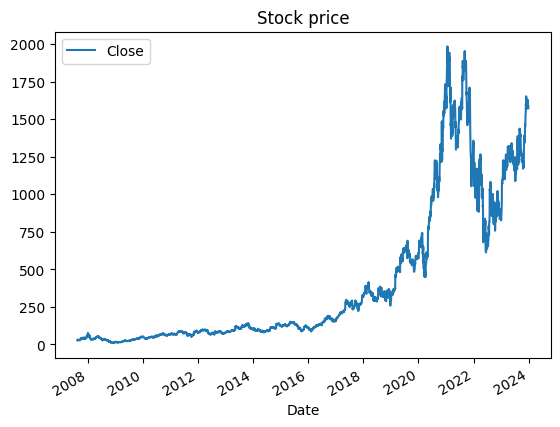

In [8]:
df.plot(x="Date", y="Close", title= 'Stock price')

In [9]:
ticker.balance_sheet

,2022-12-31,2021-12-31,2020-12-31
Ordinary Shares Number,50257751.0,50418980.0,49869727.0
Share Issued,50257751.0,50418980.0,49869727.0
Net Debt,2848000000.0,934085000.0,NaN
Total Debt,5414000000.0,3982628000.0,1708116000.0
Tangible Book Value,1649000000.0,1338474000.0,1552212000.0
...,...,...,...
Allowance For Doubtful Accounts Receivable,-14000000.0,-8349000.0,-7294000.0
Gross Accounts Receivable,144000000.0,106542000.0,56985000.0
Cash Cash Equivalents And Short Term Investments,3030000000.0,2791915000.0,3097700000.0
Other Short Term Investments,1120000000.0,207329000.0,1241306000.0


In [10]:
data = df[['Date', 'Close']].copy()

Let's to transform to logarithm

In [11]:
data['Close'] = np.log(df['Close'])

In [12]:
data.head()

,Date,Close
0,2007-08-10 00:00:00-04:00,3.318411
1,2007-08-13 00:00:00-04:00,3.423245
2,2007-08-14 00:00:00-04:00,3.370704
3,2007-08-15 00:00:00-04:00,3.320514
4,2007-08-16 00:00:00-04:00,3.304276


<AxesSubplot: title={'center': 'log Stock price'}, xlabel='Date'>

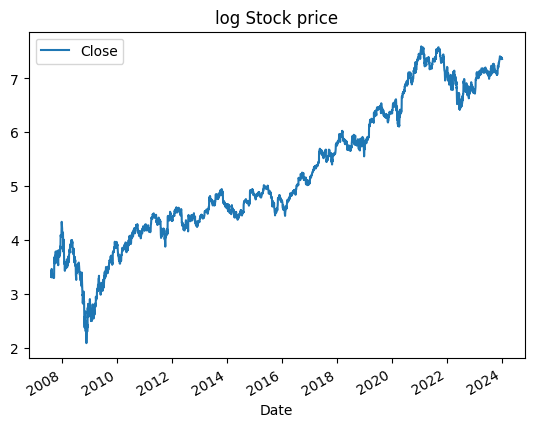

In [13]:
data.plot(x="Date", y="Close", title= 'log Stock price')

Split the dataset train and test


In [14]:
train_data = data[:int(0.8*(len(data)))]
test_data = data[int(0.8*(len(data))):]

Step 1: Check for stationary of time series

Autocorrelation 

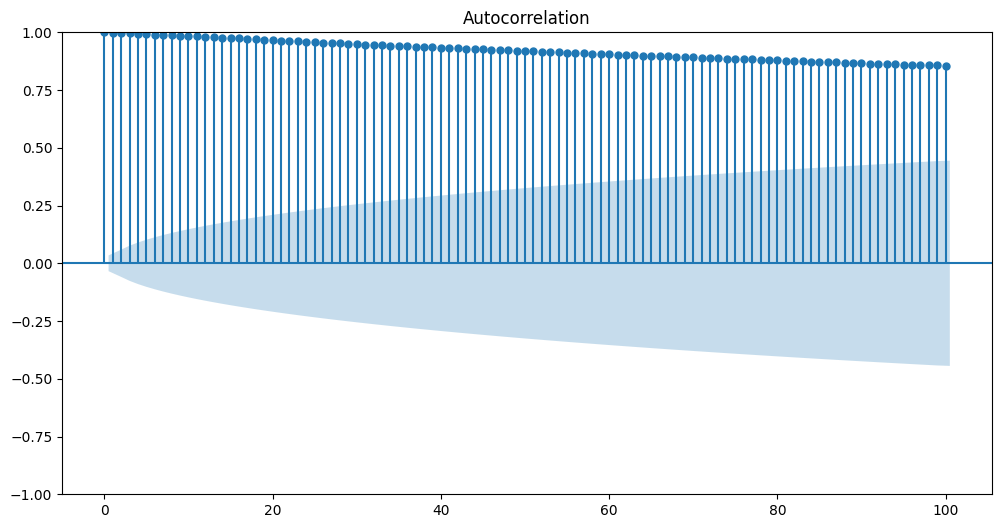

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(train_data['Close'], lags=100)
fig.set_size_inches(12, 6)

The ACF plot shows that the correlations with the lags are high and positive with slow decay. 

Partial autocorrelation 

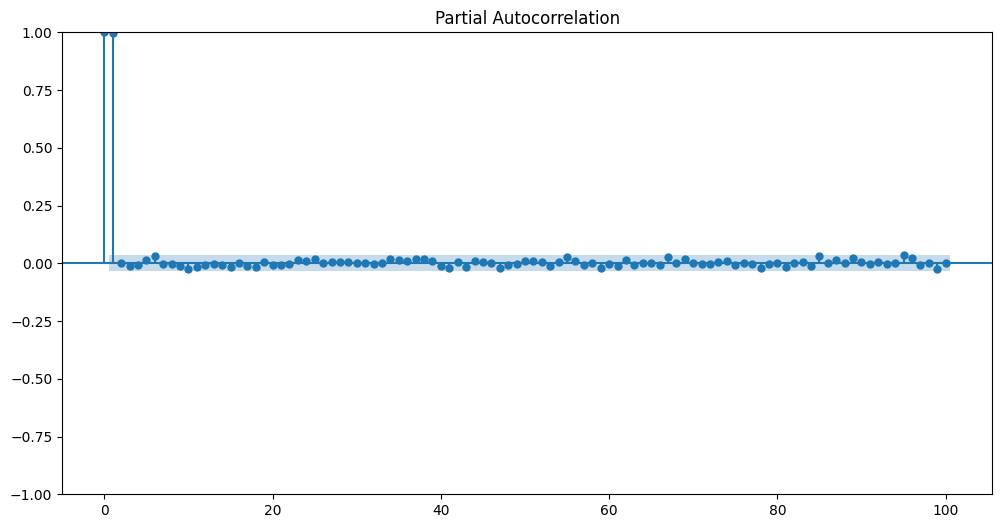

In [16]:
fig = plot_pacf(train_data['Close'], lags=100)
fig.set_size_inches(12, 6)

The PACF plot shows the partial autocorrelations having a single spike at the lag one. These are both signs of a random walk series wich is not stationary. 

Next, we can see the trend

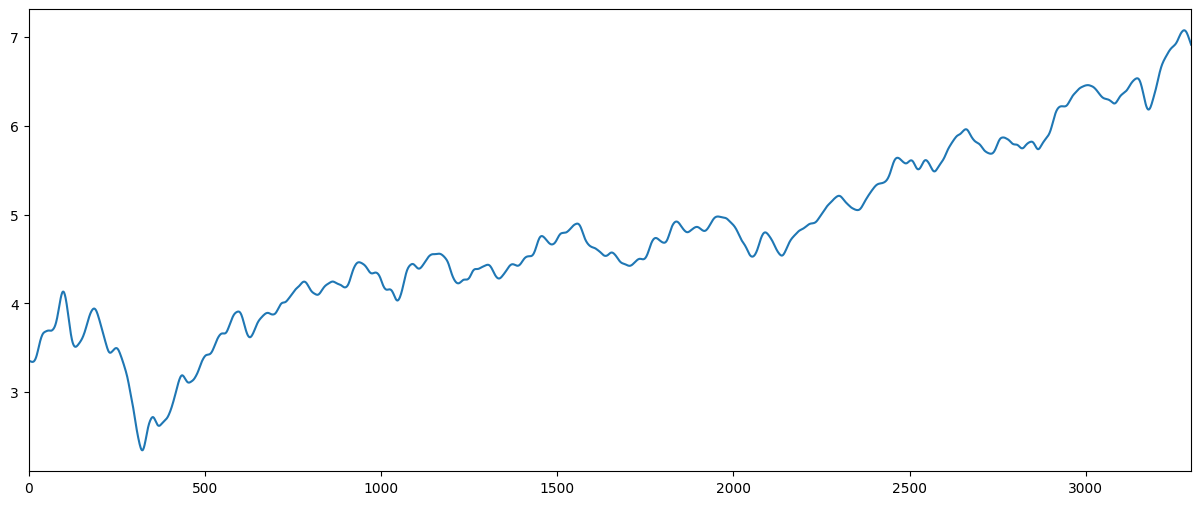

In [17]:
ticker_cycle,ticker_trend = hpfilter(train_data['Close'], lamb=1600)
ticker_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)

Separate the trend and cyclical components
from time series data by removing short-term fluctuations from the longer-term trend.

C:\Users\julie\AppData\Local\Temp\ipykernel_15504\3108711848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trend'] = ticker_trend
C:\Users\julie\AppData\Local\Temp\ipykernel_15504\3108711848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cycle'] = ticker_cycle


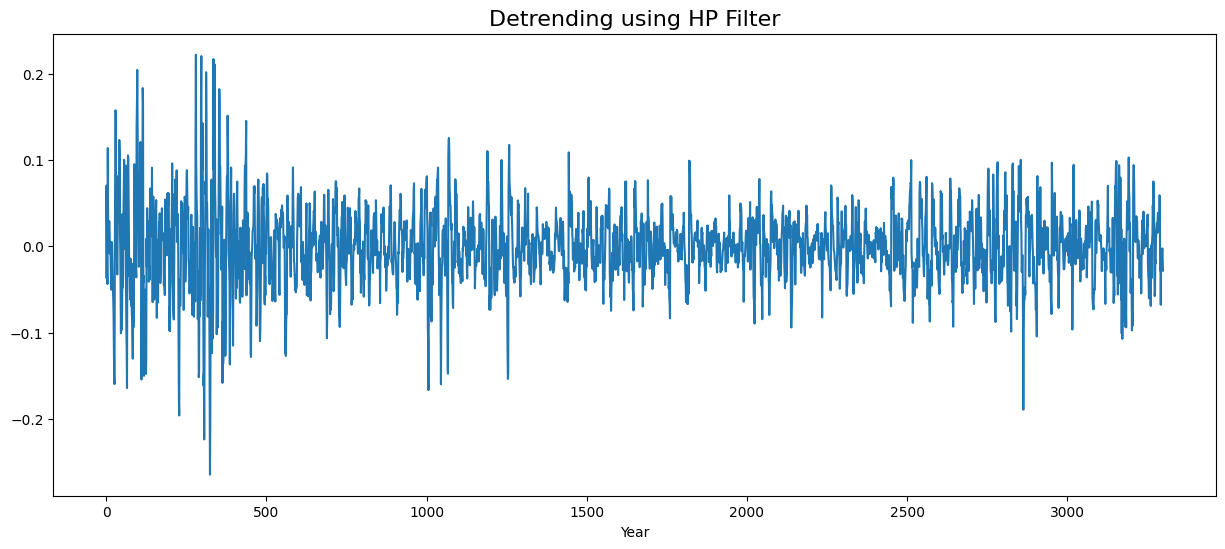

In [18]:
train_data['trend'] = ticker_trend
train_data['cycle'] = ticker_cycle

detrended = train_data.Close - train_data['trend']
plt.figure(figsize=(15,6))
plt.plot(detrended)
plt.title('Detrending using HP Filter', fontsize=16)
plt.xlabel('Year')
plt.show()

We can also check the stationarity with statistical test like the ADF test. The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample so non-stationarity.  

In [19]:

result = adfuller(train_data['Close'])
print('Test Stat: {}\np value: {}\nLags: {}\nNum \
       observations: {}'.format(result[0], result[1], 
                                result[2], result[3]))

Test Stat: -0.291226811648302
p value: 0.9267377201829987
Lags: 27
Num        observations: 3272


The Test statistic is a positive value and the p-value is 84%, meaning there is strong evidence that the Price is not stationary. 

Next, we apply a first differencing transformation. 

<AxesSubplot: >

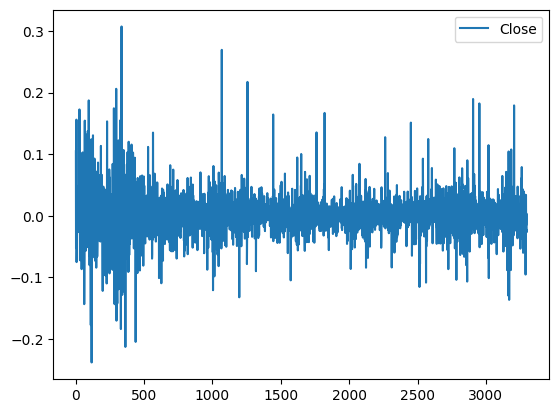

In [20]:
train_data_diff = train_data.diff().dropna()
train_data_diff.plot(y="Close")

It looks to be more stationary. 
We can also look the ACF and PACF plots of the first difference time to check the stationarity .

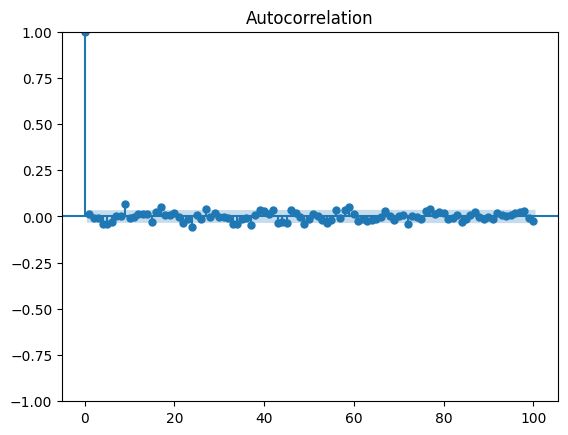

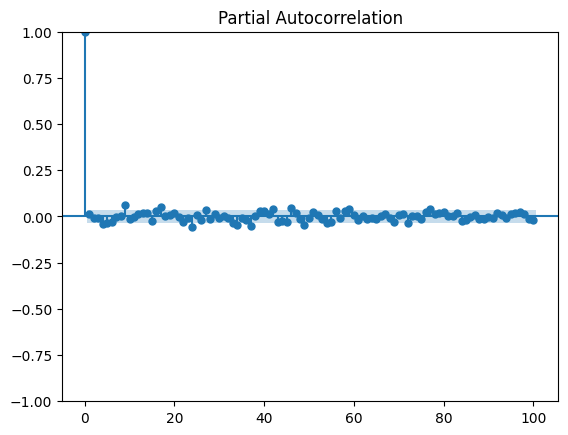

In [21]:
acf_diff = plot_acf(train_data_diff['Close'], lags=100)
pacf_diff = plot_pacf(train_data_diff['Close'], lags=100)

We can also quantify the result by running the ADF test on this transformation series.

In [22]:
adf_test = adfuller(train_data_diff['Close'])
print(f'p-value: {adf_test[1]}')
     

p-value: 3.980992373443184e-19


The p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values so the data is non-stationary.

We aply second difference time

<AxesSubplot: >

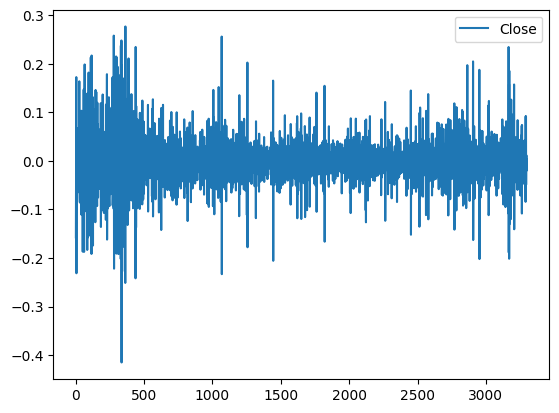

In [23]:
train_data_diff2 = train_data_diff.diff().dropna()
train_data_diff2.plot(y="Close")

In [24]:
adf_test2 = adfuller(train_data_diff2['Close'])
print(f'p-value: {adf_test2[1]}')

p-value: 4.2690571090218305e-30


The behavior of the series we're working with is totally random. Even applying second differences, it does not have a stationary behavior. 

However, we can try to predict with an ARIMA model and see its forecast.

Step 2: Determine ARIMA models parameters p,q  

Step 3: Fit the ARIMA model

In [25]:
from statsmodels.tsa.arima.model import ARIMA


In [26]:

arima = ARIMA(train_data['Close'], order=(3,2,1))
arima_fit = arima.fit()
arima_fit.summary()

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3300
Model:                 ARIMA(3, 2, 1)   Log Likelihood                6366.148
Date:                Mon, 01 Jan 2024   AIC                         -12722.297
Time:                        21:02:27   BIC                         -12691.791
Sample:                             0   HQIC                        -12711.377
                               - 3300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0131      0.012      1.061      0.289      -0.011       0.037
ar.L2         -0.0074      0.011     -0.702      0.483      -0.028       0.013
ar.L3         -0.0063      0.013     -0.486      0.627      -0.032       0.019
ma.L1         -0.9999      0.030    -33.250      0.000      -1.059      -0.941
sigma2         0.0012   3.86e-05     31.822      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10407.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Step 4: Make time series predictions

<AxesSubplot: >

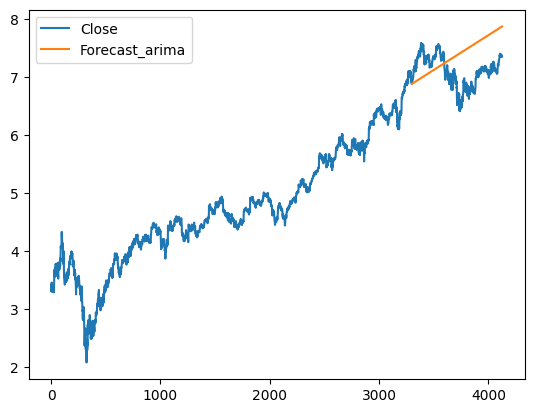

In [27]:
forecast = arima_fit.forecast(len(test_data))

data['Forecast_arima']  = [None]*len(train_data) + list(forecast)

data.plot(y=['Close', 'Forecast_arima'])

We can try Auto fit ARIMA model

In [28]:
import pmdarima as pm

In [29]:
auto_arima = pm.auto_arima(train_data['Close'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [30]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3300
Model:               SARIMAX(5, 1, 0)   Log Likelihood                6377.948
Date:                Mon, 01 Jan 2024   AIC                         -12741.895
Time:                        21:02:50   BIC                         -12699.186
Sample:                             0   HQIC                        -12726.607
                               - 3300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.897      0.058   -3.87e-05       0.002
ar.L1          0.0107      0.013      0.852      0.394      -0.014       0.035
ar.L2         -0.0084      0.011     -0.791      0.429      -0.029       0.012
ar.L3         -0.0064      0.013     -0.486      0.627      -0.032       0.019
ar.L4         -0.0417      0.011     -3.641      0.000      -0.064      -0.019
ar.L5         -0.0382      0.011     -3.490      0.000      -0.060      -0.017
sigma2         0.0012   1.36e-05     90.070      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10250.18
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: >

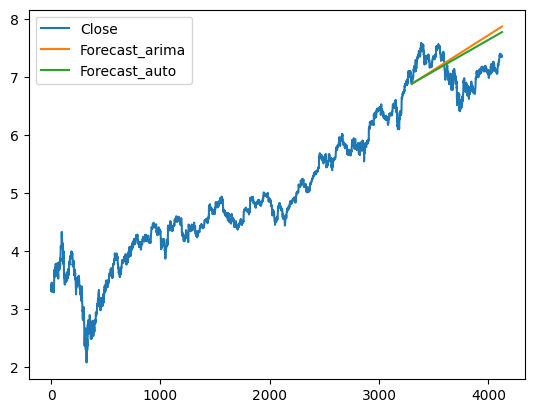

In [31]:
forecast_auto = auto_arima.predict(n_periods=len(test_data))

data['Forecast_auto']  = [None]*len(train_data) + list(forecast_auto)

data.plot(y=['Close', 'Forecast_arima', 'Forecast_auto'])

Step 5: Evaluate model predictions

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [33]:
mae = mean_absolute_error(test_data['Close'], forecast)
mape = mean_absolute_percentage_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))

print(f' mae manual: {mae} mape manual: {mape} rmse manual: {rmse} ')

 mae manual: 0.46753059688047 mape manual: 0.06653155903917933 rmse manual: 0.5192528583541708 


In [34]:
mae = mean_absolute_error(test_data['Close'], forecast_auto)
mape = mean_absolute_percentage_error(test_data['Close'], forecast_auto)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast_auto))

print(f' mae auto: {mae} mape auto: {mape} rmse auto: {rmse} ')

 mae auto: 0.4314143504669023 mape auto: 0.061346712906864026 rmse auto: 0.47547615811955274 


# Time series forecasting with Prophet 

In [35]:
import prophet as prophet

In [36]:
prophet_data = pd.DataFrame({'ds': df.Date, 'y': df.Close})

In [38]:
prophet_data["ds"] = prophet_data["ds"].dt.date


In [40]:
prophet_data.head()

,ds,y
0,2007-08-10,27.616434
1,2007-08-13,30.668776
2,2007-08-14,29.099003
3,2007-08-15,27.674578
4,2007-08-16,27.228834


In [41]:
model = prophet.Prophet()
model.fit(prophet_data)

21:04:12 - cmdstanpy - INFO - Chain [1] start processing
21:04:13 - cmdstanpy - INFO - Chain [1] done processing


Set the period for train

In [52]:
future_prophet = model.make_future_dataframe(periods=len(test_data))

forecast_prophet = model.predict(future_prophet)
forecast_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-08-10,19.571882,-131.100146,204.736649,19.571882,19.571882,25.374666,25.374666,25.374666,-1.370128,-1.370128,-1.370128,26.744794,26.744794,26.744794,0.0,0.0,0.0,44.946549
1,2007-08-13,19.677807,-133.765933,222.979842,19.677807,19.677807,26.549435,26.549435,26.549435,-1.304506,-1.304506,-1.304506,27.853941,27.853941,27.853941,0.0,0.0,0.0,46.227242
2,2007-08-14,19.713116,-127.644782,235.971499,19.713116,19.713116,26.268607,26.268607,26.268607,-1.657245,-1.657245,-1.657245,27.925851,27.925851,27.925851,0.0,0.0,0.0,45.981722
3,2007-08-15,19.748424,-133.115336,227.997618,19.748424,19.748424,26.220748,26.220748,26.220748,-1.654452,-1.654452,-1.654452,27.875200,27.875200,27.875200,0.0,0.0,0.0,45.969172
4,2007-08-16,19.783732,-133.744250,220.626438,19.783732,19.783732,26.107681,26.107681,26.107681,-1.611731,-1.611731,-1.611731,27.719411,27.719411,27.719411,0.0,0.0,0.0,45.891413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4947,2026-03-30,1006.825775,590.740078,1403.168795,643.399603,1341.650792,-8.392638,-8.392638,-8.392638,-1.304506,-1.304506,-1.304506,-7.088132,-7.088132,-7.088132,0.0,0.0,0.0,998.433137
4948,2026-03-31,1006.662746,603.658304,1378.690293,642.749325,1341.972044,-7.507062,-7.507062,-7.507062,-1.657245,-1.657245,-1.657245,-5.849818,-5.849818,-5.849818,0.0,0.0,0.0,999.155684
4949,2026-04-01,1006.499717,612.379453,1388.763707,642.099046,1342.293295,-6.216393,-6.216393,-6.216393,-1.654452,-1.654452,-1.654452,-4.561941,-4.561941,-4.561941,0.0,0.0,0.0,1000.283325
4950,2026-04-02,1006.336689,581.664900,1387.681529,641.448767,1342.614547,-4.860996,-4.860996,-4.860996,-1.611731,-1.611731,-1.611731,-3.249266,-3.249266,-3.249266,0.0,0.0,0.0,1001.475692


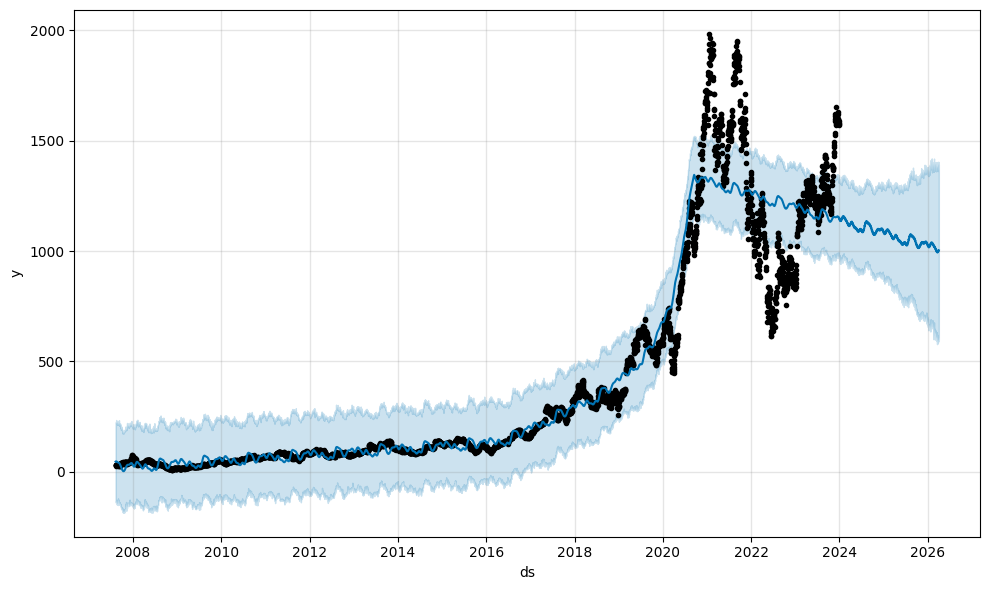

In [49]:
model.plot(forecast_prophet)
plt.show()

We can look trend, seasonal, period components

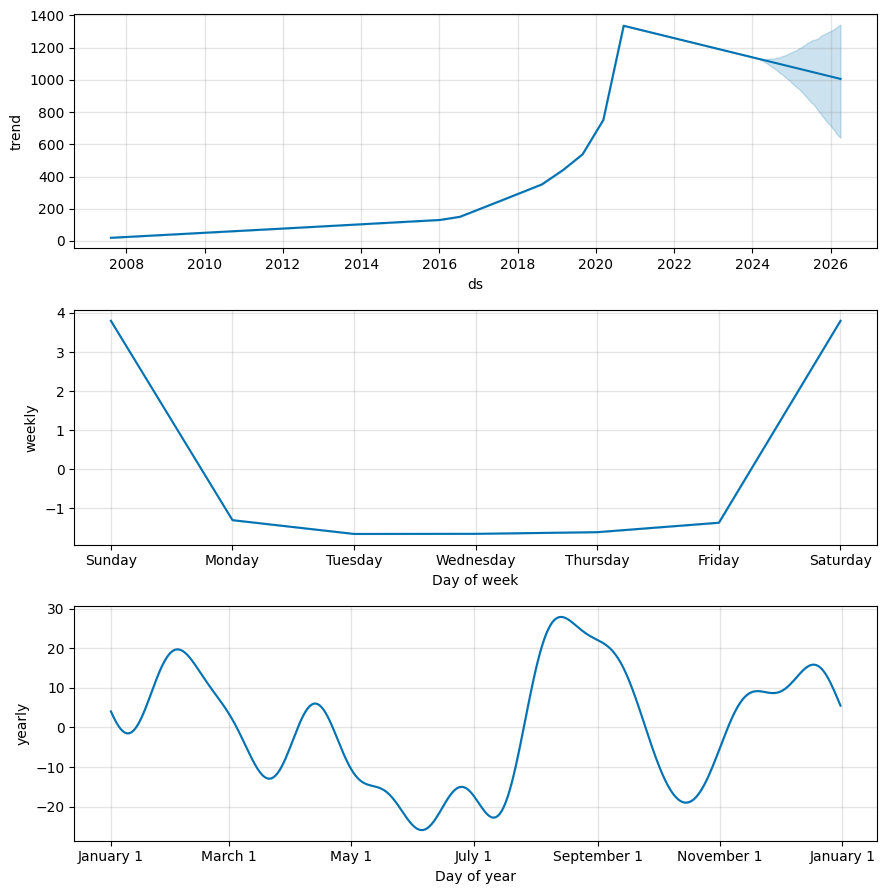

In [53]:
model.plot_components(forecast_prophet)
plt.show()

To assess how well our model works, we will perform a cross validation.

In [54]:
from prophet.diagnostics import cross_validation

prophet_cv = cross_validation(model,
                              initial='730 days',
                              period='180 days',
                              horizon='365 days')
prophet_cv

  0%|          | 0/28 [00:00<?, ?it/s]

21:15:42 - cmdstanpy - INFO - Chain [1] start processing
21:15:42 - cmdstanpy - INFO - Chain [1] done processing
21:15:42 - cmdstanpy - INFO - Chain [1] start processing
21:15:42 - cmdstanpy - INFO - Chain [1] done processing
21:15:43 - cmdstanpy - INFO - Chain [1] start processing
21:15:43 - cmdstanpy - INFO - Chain [1] done processing
21:15:43 - cmdstanpy - INFO - Chain [1] start processing
21:15:43 - cmdstanpy - INFO - Chain [1] done processing
21:15:43 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing
21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing
21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:44 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2009-09-09,29.725544,25.244405,34.158321,33.168785,2009-09-08
1,2009-09-10,29.882821,25.719565,34.923243,33.566082,2009-09-08
2,2009-09-11,30.046258,25.129284,34.501907,33.033131,2009-09-08
3,2009-09-14,30.183945,25.527882,34.884933,31.947853,2009-09-08
4,2009-09-15,30.251649,25.684353,35.049882,31.841270,2009-09-08
...,...,...,...,...,...,...
7037,2023-12-22,1425.963489,1179.073889,1672.005138,1589.079956,2022-12-29
7038,2023-12-26,1435.279997,1197.340601,1675.926612,1576.640015,2022-12-29
7039,2023-12-27,1437.730474,1191.976261,1670.820810,1590.880005,2022-12-29
7040,2023-12-28,1439.417056,1201.587226,1654.551217,1581.599976,2022-12-29


In [56]:
from prophet.diagnostics import performance_metrics

prophet_performance = performance_metrics(prophet_cv)
prophet_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,73663.198229,271.409650,129.533390,0.220271,0.162234,0.205787,0.249148
1,38 days,74697.085192,273.307675,131.035516,0.223003,0.165128,0.208182,0.243924
2,39 days,75362.064507,274.521519,132.112391,0.223778,0.165014,0.208993,0.244476
3,40 days,74458.303746,272.870489,131.488264,0.222129,0.163035,0.208159,0.248056
4,41 days,73658.996083,271.401909,130.712816,0.220734,0.160737,0.207394,0.250000
...,...,...,...,...,...,...,...,...
324,361 days,182962.874802,427.741598,225.572339,0.349572,0.253122,0.317027,0.331863
325,362 days,182956.130048,427.733714,225.889328,0.350144,0.253599,0.317450,0.329545
326,363 days,184963.288784,430.073585,227.546921,0.352034,0.254166,0.319375,0.329545
327,364 days,188587.315721,434.266411,229.977284,0.355275,0.255648,0.322001,0.328125


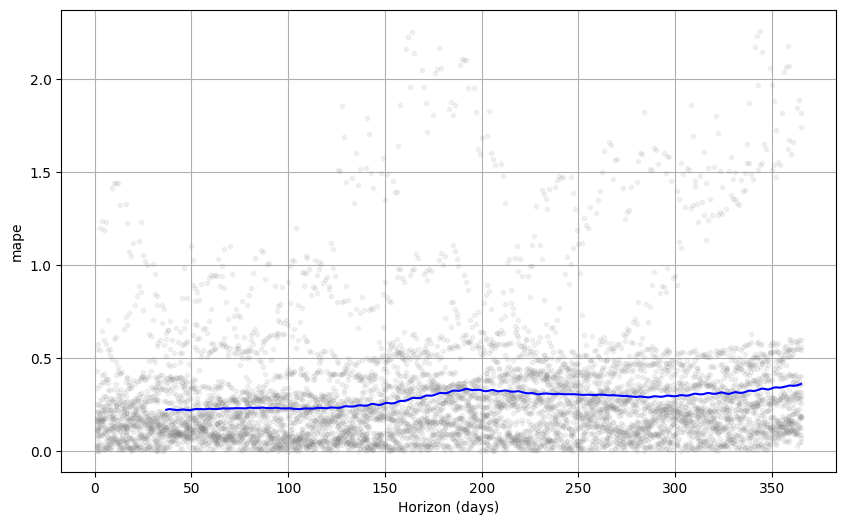

In [57]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(prophet_cv, metric='mape')

The accuracy of predictions decreases as the prediction horizon expands. We see that the error for the first few days is 22% and increases to almost 36%.